<a href="https://colab.research.google.com/github/Seenuprime/Projects/blob/main/American_Sign_Language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Deep Learning Model with Transfer Learning Using Pretrained EfficientNetB0 model for Predicting Hand signs

In [1]:
import tensorflow as tf
import pandas as pd
import cv2 as cv

## Loading the data from Kaggle

In [2]:
!kaggle datasets download -d kapillondhe/american-sign-language

Dataset URL: https://www.kaggle.com/datasets/kapillondhe/american-sign-language
License(s): GPL-2.0
100% 4.64G/4.64G [01:02<00:00, 93.2MB/s]
100% 4.64G/4.64G [01:02<00:00, 79.2MB/s]


In [3]:
import zipfile
dir = 'american-sign-language.zip'
zip_ref = zipfile.ZipFile(dir)
zip_ref.extractall()
zip_ref.close()

## Ploting some random images

In [4]:
import random
import cv2 as cv
import matplotlib.pyplot as plt
import os
def plot_rand_images(path):
  plt.figure(figsize=(12, 6))
  for i in range(10):
    plt.subplot(2, 5, i+1)
    rand_class = random.choice(os.listdir(path))
    rand_image_file = random.choice(os.listdir(os.path.join(path, rand_class)))
    image = cv.imread(os.path.join(path, rand_class, rand_image_file))
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(rand_class)
    plt.axis(False)
  plt.tight_layout()

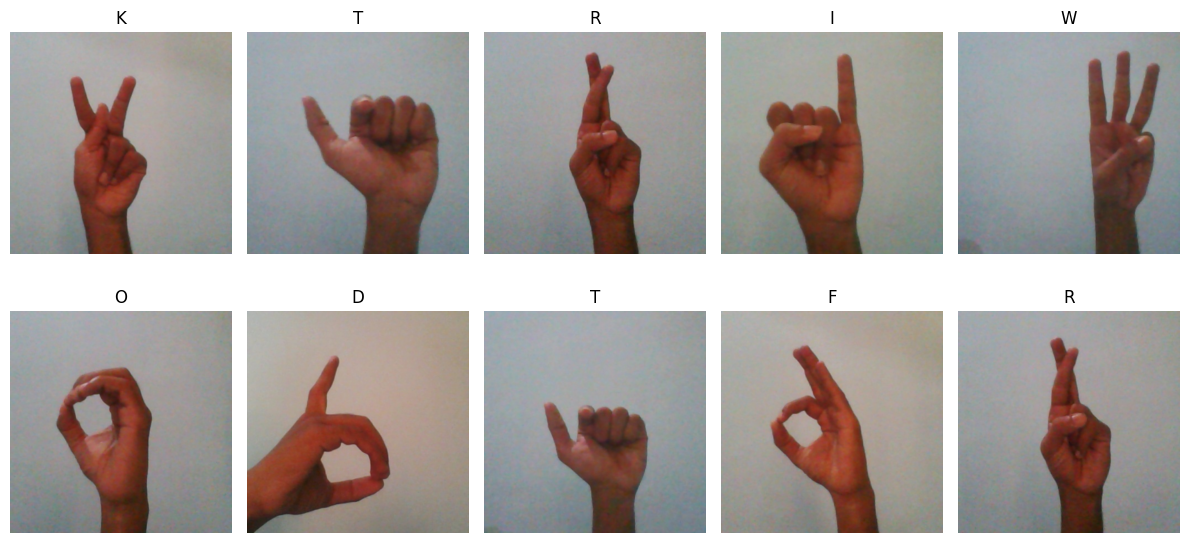

In [5]:
plot_rand_images('/content/ASL_Dataset/Train')

## Loading the data and turning them into batches and splitting

In [6]:
train, val = tf.keras.preprocessing.image_dataset_from_directory('/content/ASL_Dataset/Train',
                                                                label_mode='int',
                                                                image_size=(64, 64),
                                                                validation_split=0.2,
                                                                subset='both',
                                                                 color_mode='grayscale',
                                                                 seed=42)

test = tf.keras.preprocessing.image_dataset_from_directory('/content/ASL_Dataset/Test',
                                                           label_mode='int',
                                                           image_size=(64, 64),
                                                           color_mode='grayscale')

Found 165670 files belonging to 28 classes.
Using 132536 files for training.
Using 33134 files for validation.
Found 112 files belonging to 28 classes.


## Getting the class names

In [7]:
import pathlib
dir = pathlib.Path('/content/ASL_Dataset/Train')
class_names = sorted(os.listdir(dir))
len(class_names), class_names[:10]

(28, ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])

In [8]:
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'Nothing', 'O', 'P', 'Q', 'R', 'S', 'Space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


## Ploting the random images after loading and preprocessing

In [9]:
def plot_from_loaded(images, labels):
  plt.figure(figsize=(10, 10))
  for i in range(0, 20):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis(False)
  plt.tight_layout()

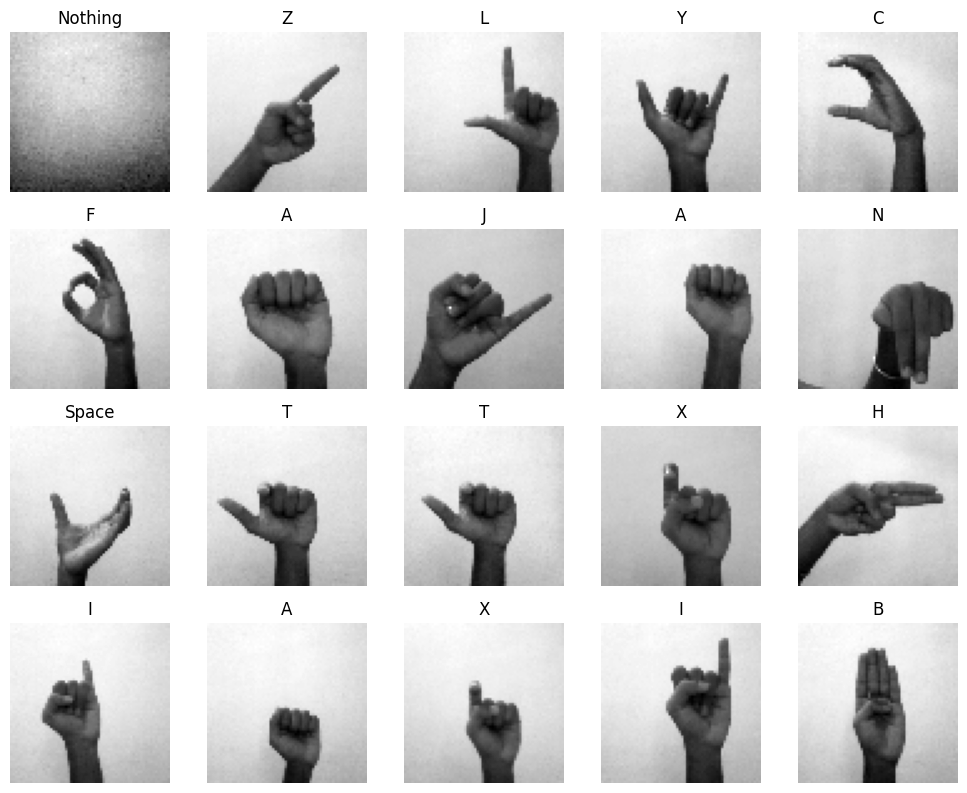

In [10]:
for images, labels in train.take(1):
  plot_from_loaded(images, labels)

## Creating Model Checkpoint

In [11]:
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint('model_checkpoint/Hand_sign_model.ckpt',
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                     save_freq='epoch')

## Prefetching the data to run quicker

In [12]:
train = train.prefetch(tf.data.experimental.AUTOTUNE)
val = val.prefetch(tf.data.experimental.AUTOTUNE)
test = test.prefetch(tf.data.experimental.AUTOTUNE)

## Building and training the model

In [13]:
base_model = tf.keras.applications.EfficientNetB1(include_top=False)
base_model.trainable = False

input = tf.keras.layers.Input(shape=(64, 64, 1))

x = base_model(input)

x = tf.keras.layers.AveragePooling2D(2)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)

x = tf.keras.layers.Flatten()(x)

output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model = tf.keras.Model(input, output)

27018416/27018416 [==============================] - 0s 0us/step


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 efficientnetb1 (Functional  (None, None, None, 1280   6575239   
 )                           )                                   
                                                                 
 average_pooling2d (Average  (None, 1, 1, 1280)        0         
 Pooling2D)                                                      
                                                                 
 dense (Dense)               (None, 1, 1, 128)         163968    
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 28)                3612  

In [15]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [16]:
history=model.fit(train,
                  epochs=5,
                  batch_size=32,
                  validation_data=val,
                  validation_steps=int(len(val) * 0.25),
                  callbacks=[modelcheckpoint])

Epoch 1/5
4142/4142 [==============================] - 1188s 283ms/step - loss: 0.0439 - accuracy: 0.9886 - val_loss: 0.0046 - val_accuracy: 0.9986
Epoch 2/5
4142/4142 [==============================] - 1135s 274ms/step - loss: 0.0115 - accuracy: 0.9964 - val_loss: 0.0023 - val_accuracy: 0.9990
Epoch 3/5
4142/4142 [==============================] - 1139s 274ms/step - loss: 0.0090 - accuracy: 0.9971 - val_loss: 0.0032 - val_accuracy: 0.9986
Epoch 4/5
4142/4142 [==============================] - 1147s 277ms/step - loss: 0.0084 - accuracy: 0.9974 - val_loss: 0.0027 - val_accuracy: 0.9995
Epoch 5/5
4142/4142 [==============================] - 1136s 274ms/step - loss: 0.0076 - accuracy: 0.9976 - val_loss: 0.0022 - val_accuracy: 0.9995


## Evaluating the model with validation data

In [17]:
model_eval = model.evaluate(val)

1036/1036 [==============================] - 266s 256ms/step - loss: 0.0015 - accuracy: 0.9995


In [30]:
model.save('Sign_Language_Model.keras')

In [31]:
loaded_model = tf.keras.models.load_model('Sign_Language_Model.keras')
loaded_model.evaluate(val)

1036/1036 [==============================] - 261s 246ms/step - loss: 0.0015 - accuracy: 0.9995


[0.0015392813365906477, 0.9994869232177734]

##Predicting on our own images

In [ ]:
def preprocess_pred_plot(image_file):
  image_org = cv.imread(image_file)
  image = cv.cvtColor(image_org, cv.COLOR_BGR2GRAY)
  image = cv.resize(image, (64, 64))
  image = tf.expand_dims(image, axis=-1)
  image = tf.expand_dims(image, axis=0)

  pred = model.predict(image).argmax()
  plt.imshow(cv.cvtColor(image_org, cv.COLOR_BGR2RGB))
  plt.title(f"Predicted: {class_names[pred]}")
  plt.axis(False)

1/1 [==============================] - 0s 53ms/step


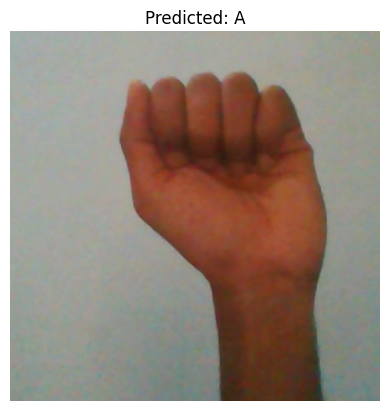

In [27]:
preprocess_pred_plot('/content/ASL_Dataset/Train/A/10.jpg')

1/1 [==============================] - 0s 202ms/step


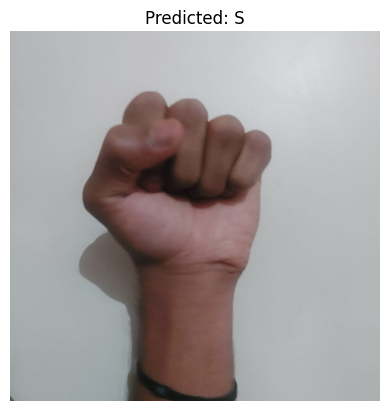

In [29]:
preprocess_pred_plot('sign1.jpeg')